In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):

    nfeatures = 100
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                concave_list=None,
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########


Main effects training epoch: 1, train loss: 0.02386, val loss: 0.02334
Main effects training epoch: 2, train loss: 0.02172, val loss: 0.02159
Main effects training epoch: 3, train loss: 0.02152, val loss: 0.02131
Main effects training epoch: 4, train loss: 0.02140, val loss: 0.02124
Main effects training epoch: 5, train loss: 0.02129, val loss: 0.02115
Main effects training epoch: 6, train loss: 0.02116, val loss: 0.02102
Main effects training epoch: 7, train loss: 0.02103, val loss: 0.02089
Main effects training epoch: 8, train loss: 0.02089, val loss: 0.02076
Main effects training epoch: 9, train loss: 0.02070, val loss: 0.02060
Main effects training epoch: 10, train loss: 0.02049, val loss: 0.02041
Main effects training epoch: 11, train loss: 0.02027, val loss: 0.02019
Main effects training epoch: 12, train loss: 0.01999, val loss: 0.01996
Main effects training epoch: 13, train loss: 0.01971, val loss: 0.01968
Main effects training epoch: 14, train loss: 0.01942, val loss: 0.01942
M

Main effects training epoch: 115, train loss: 0.01228, val loss: 0.01269
Main effects training epoch: 116, train loss: 0.01242, val loss: 0.01292
Main effects training epoch: 117, train loss: 0.01220, val loss: 0.01265
Main effects training epoch: 118, train loss: 0.01218, val loss: 0.01261
Main effects training epoch: 119, train loss: 0.01216, val loss: 0.01263
Main effects training epoch: 120, train loss: 0.01217, val loss: 0.01266
Main effects training epoch: 121, train loss: 0.01208, val loss: 0.01253
Main effects training epoch: 122, train loss: 0.01214, val loss: 0.01258
Main effects training epoch: 123, train loss: 0.01204, val loss: 0.01250
Main effects training epoch: 124, train loss: 0.01199, val loss: 0.01246
Main effects training epoch: 125, train loss: 0.01197, val loss: 0.01246
Main effects training epoch: 126, train loss: 0.01197, val loss: 0.01244
Main effects training epoch: 127, train loss: 0.01197, val loss: 0.01244
Main effects training epoch: 128, train loss: 0.011

Main effects training epoch: 228, train loss: 0.01114, val loss: 0.01193
Main effects training epoch: 229, train loss: 0.01115, val loss: 0.01196
Main effects training epoch: 230, train loss: 0.01113, val loss: 0.01192
Main effects training epoch: 231, train loss: 0.01123, val loss: 0.01202
Main effects training epoch: 232, train loss: 0.01115, val loss: 0.01196
Main effects training epoch: 233, train loss: 0.01116, val loss: 0.01196
Main effects training epoch: 234, train loss: 0.01126, val loss: 0.01205
Main effects training epoch: 235, train loss: 0.01128, val loss: 0.01209
Main effects training epoch: 236, train loss: 0.01113, val loss: 0.01193
Main effects training epoch: 237, train loss: 0.01113, val loss: 0.01194
Main effects training epoch: 238, train loss: 0.01118, val loss: 0.01199
Main effects training epoch: 239, train loss: 0.01114, val loss: 0.01193
Main effects training epoch: 240, train loss: 0.01111, val loss: 0.01192
Main effects training epoch: 241, train loss: 0.011

Main effects training epoch: 341, train loss: 0.01098, val loss: 0.01191
Main effects training epoch: 342, train loss: 0.01097, val loss: 0.01190
Main effects training epoch: 343, train loss: 0.01096, val loss: 0.01191
Main effects training epoch: 344, train loss: 0.01104, val loss: 0.01198
Early stop at epoch 344, with validation loss: 0.01198
##########Stage 1: main effect training stop.##########
##########Stage 2: interaction training start.##########


Interaction training epoch: 1, train loss: 1.55337, val loss: 1.55824
Interaction training epoch: 2, train loss: 0.45293, val loss: 0.45689
Interaction training epoch: 3, train loss: 0.15024, val loss: 0.15680
Interaction training epoch: 4, train loss: 0.13384, val loss: 0.13924
Interaction training epoch: 5, train loss: 0.12565, val loss: 0.13098
Interaction training epoch: 6, train loss: 0.11885, val loss: 0.12392
Interaction training epoch: 7, train loss: 0.11269, val loss: 0.11753
Interaction training epoch: 8, train loss: 0.10703, val loss: 0.11167
Interaction training epoch: 9, train loss: 0.10182, val loss: 0.10629
Interaction training epoch: 10, train loss: 0.09702, val loss: 0.10129
Interaction training epoch: 11, train loss: 0.09256, val loss: 0.09667
Interaction training epoch: 12, train loss: 0.08836, val loss: 0.09231
Interaction training epoch: 13, train loss: 0.08444, val loss: 0.08822
Interaction training epoch: 14, train loss: 0.08074, val loss: 0.08439
Interaction tra

Interaction training epoch: 117, train loss: 0.00942, val loss: 0.00970
Interaction training epoch: 118, train loss: 0.00930, val loss: 0.00958
Interaction training epoch: 119, train loss: 0.00920, val loss: 0.00947
Interaction training epoch: 120, train loss: 0.00913, val loss: 0.00941
Interaction training epoch: 121, train loss: 0.00901, val loss: 0.00929
Interaction training epoch: 122, train loss: 0.00891, val loss: 0.00918
Interaction training epoch: 123, train loss: 0.00881, val loss: 0.00907
Interaction training epoch: 124, train loss: 0.00876, val loss: 0.00903
Interaction training epoch: 125, train loss: 0.00868, val loss: 0.00895
Interaction training epoch: 126, train loss: 0.00861, val loss: 0.00888
Interaction training epoch: 127, train loss: 0.00851, val loss: 0.00876
Interaction training epoch: 128, train loss: 0.00841, val loss: 0.00866
Interaction training epoch: 129, train loss: 0.00835, val loss: 0.00860
Interaction training epoch: 130, train loss: 0.00827, val loss: 

Interaction training epoch: 231, train loss: 0.00541, val loss: 0.00559
Interaction training epoch: 232, train loss: 0.00541, val loss: 0.00558
Interaction training epoch: 233, train loss: 0.00538, val loss: 0.00555
Interaction training epoch: 234, train loss: 0.00536, val loss: 0.00554
Interaction training epoch: 235, train loss: 0.00538, val loss: 0.00557
Interaction training epoch: 236, train loss: 0.00540, val loss: 0.00552
Interaction training epoch: 237, train loss: 0.00534, val loss: 0.00552
Interaction training epoch: 238, train loss: 0.00535, val loss: 0.00553
Interaction training epoch: 239, train loss: 0.00537, val loss: 0.00557
Interaction training epoch: 240, train loss: 0.00529, val loss: 0.00546
Interaction training epoch: 241, train loss: 0.00528, val loss: 0.00545
Interaction training epoch: 242, train loss: 0.00531, val loss: 0.00550
Interaction training epoch: 243, train loss: 0.00531, val loss: 0.00550
Interaction training epoch: 244, train loss: 0.00523, val loss: 

Interaction training epoch: 345, train loss: 0.00417, val loss: 0.00429
Interaction training epoch: 346, train loss: 0.00417, val loss: 0.00426
Interaction training epoch: 347, train loss: 0.00407, val loss: 0.00420
Interaction training epoch: 348, train loss: 0.00407, val loss: 0.00418
Interaction training epoch: 349, train loss: 0.00407, val loss: 0.00419
Interaction training epoch: 350, train loss: 0.00419, val loss: 0.00435
Interaction training epoch: 351, train loss: 0.00409, val loss: 0.00420
Interaction training epoch: 352, train loss: 0.00404, val loss: 0.00417
Interaction training epoch: 353, train loss: 0.00400, val loss: 0.00412
Interaction training epoch: 354, train loss: 0.00409, val loss: 0.00423
Interaction training epoch: 355, train loss: 0.00399, val loss: 0.00408
Interaction training epoch: 356, train loss: 0.00399, val loss: 0.00411
Interaction training epoch: 357, train loss: 0.00397, val loss: 0.00408
Interaction training epoch: 358, train loss: 0.00404, val loss: 

Interaction training epoch: 459, train loss: 0.00309, val loss: 0.00313
Interaction training epoch: 460, train loss: 0.00312, val loss: 0.00319
Interaction training epoch: 461, train loss: 0.00306, val loss: 0.00315
Interaction training epoch: 462, train loss: 0.00306, val loss: 0.00313
Interaction training epoch: 463, train loss: 0.00306, val loss: 0.00315
Interaction training epoch: 464, train loss: 0.00307, val loss: 0.00312
Interaction training epoch: 465, train loss: 0.00315, val loss: 0.00325
Interaction training epoch: 466, train loss: 0.00301, val loss: 0.00306
Interaction training epoch: 467, train loss: 0.00303, val loss: 0.00306
Interaction training epoch: 468, train loss: 0.00302, val loss: 0.00307
Interaction training epoch: 469, train loss: 0.00304, val loss: 0.00309
Interaction training epoch: 470, train loss: 0.00305, val loss: 0.00311
Interaction training epoch: 471, train loss: 0.00305, val loss: 0.00310
Interaction training epoch: 472, train loss: 0.00298, val loss: 

Fine tuning epoch: 84, train loss: 0.00266, val loss: 0.00277
Fine tuning epoch: 85, train loss: 0.00267, val loss: 0.00273
Fine tuning epoch: 86, train loss: 0.00270, val loss: 0.00275
Fine tuning epoch: 87, train loss: 0.00261, val loss: 0.00267
Fine tuning epoch: 88, train loss: 0.00263, val loss: 0.00273
Fine tuning epoch: 89, train loss: 0.00265, val loss: 0.00271
Fine tuning epoch: 90, train loss: 0.00268, val loss: 0.00272
Fine tuning epoch: 91, train loss: 0.00267, val loss: 0.00273
Fine tuning epoch: 92, train loss: 0.00260, val loss: 0.00268
Fine tuning epoch: 93, train loss: 0.00271, val loss: 0.00275
Fine tuning epoch: 94, train loss: 0.00262, val loss: 0.00268
Fine tuning epoch: 95, train loss: 0.00260, val loss: 0.00267
Fine tuning epoch: 96, train loss: 0.00267, val loss: 0.00270
Fine tuning epoch: 97, train loss: 0.00262, val loss: 0.00269
Fine tuning epoch: 98, train loss: 0.00260, val loss: 0.00267
Fine tuning epoch: 99, train loss: 0.00267, val loss: 0.00276
Fine tun

Fine tuning epoch: 215, train loss: 0.00252, val loss: 0.00262
Fine tuning epoch: 216, train loss: 0.00264, val loss: 0.00272
Fine tuning epoch: 217, train loss: 0.00260, val loss: 0.00270
Fine tuning epoch: 218, train loss: 0.00265, val loss: 0.00274
Fine tuning epoch: 219, train loss: 0.00258, val loss: 0.00271
Fine tuning epoch: 220, train loss: 0.00258, val loss: 0.00269
Fine tuning epoch: 221, train loss: 0.00257, val loss: 0.00264
Fine tuning epoch: 222, train loss: 0.00258, val loss: 0.00269
Fine tuning epoch: 223, train loss: 0.00270, val loss: 0.00279
Fine tuning epoch: 224, train loss: 0.00251, val loss: 0.00260
Fine tuning epoch: 225, train loss: 0.00261, val loss: 0.00270
Fine tuning epoch: 226, train loss: 0.00251, val loss: 0.00260
Fine tuning epoch: 227, train loss: 0.00250, val loss: 0.00258
Fine tuning epoch: 228, train loss: 0.00267, val loss: 0.00279
Fine tuning epoch: 229, train loss: 0.00259, val loss: 0.00273
Fine tuning epoch: 230, train loss: 0.00254, val loss: 

Fine tuning epoch: 346, train loss: 0.00248, val loss: 0.00258
Fine tuning epoch: 347, train loss: 0.00246, val loss: 0.00257
Fine tuning epoch: 348, train loss: 0.00245, val loss: 0.00257
Fine tuning epoch: 349, train loss: 0.00245, val loss: 0.00254
Fine tuning epoch: 350, train loss: 0.00248, val loss: 0.00257
Fine tuning epoch: 351, train loss: 0.00261, val loss: 0.00269
Fine tuning epoch: 352, train loss: 0.00245, val loss: 0.00257
Fine tuning epoch: 353, train loss: 0.00259, val loss: 0.00268
Fine tuning epoch: 354, train loss: 0.00245, val loss: 0.00256
Fine tuning epoch: 355, train loss: 0.00253, val loss: 0.00262
Fine tuning epoch: 356, train loss: 0.00249, val loss: 0.00256
Fine tuning epoch: 357, train loss: 0.00249, val loss: 0.00262
Fine tuning epoch: 358, train loss: 0.00277, val loss: 0.00289
Fine tuning epoch: 359, train loss: 0.00254, val loss: 0.00266
Fine tuning epoch: 360, train loss: 0.00249, val loss: 0.00261
Fine tuning epoch: 361, train loss: 0.00254, val loss: 

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

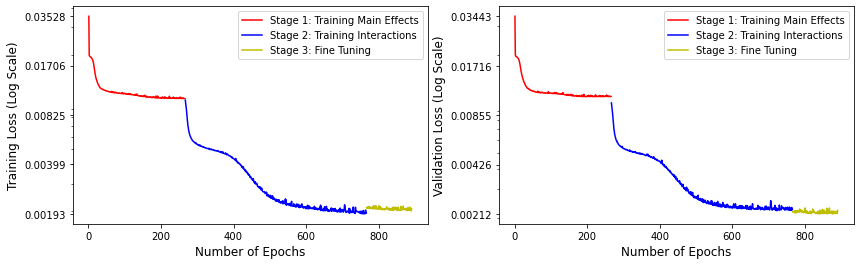

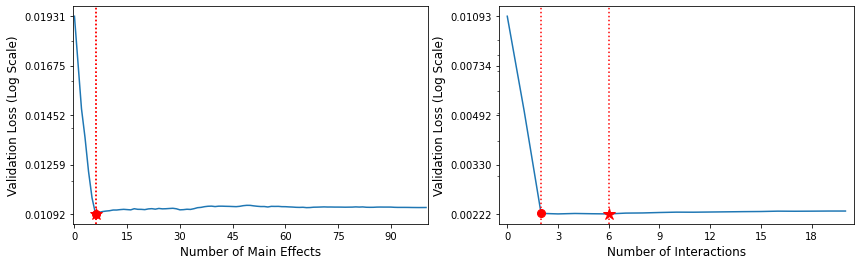

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

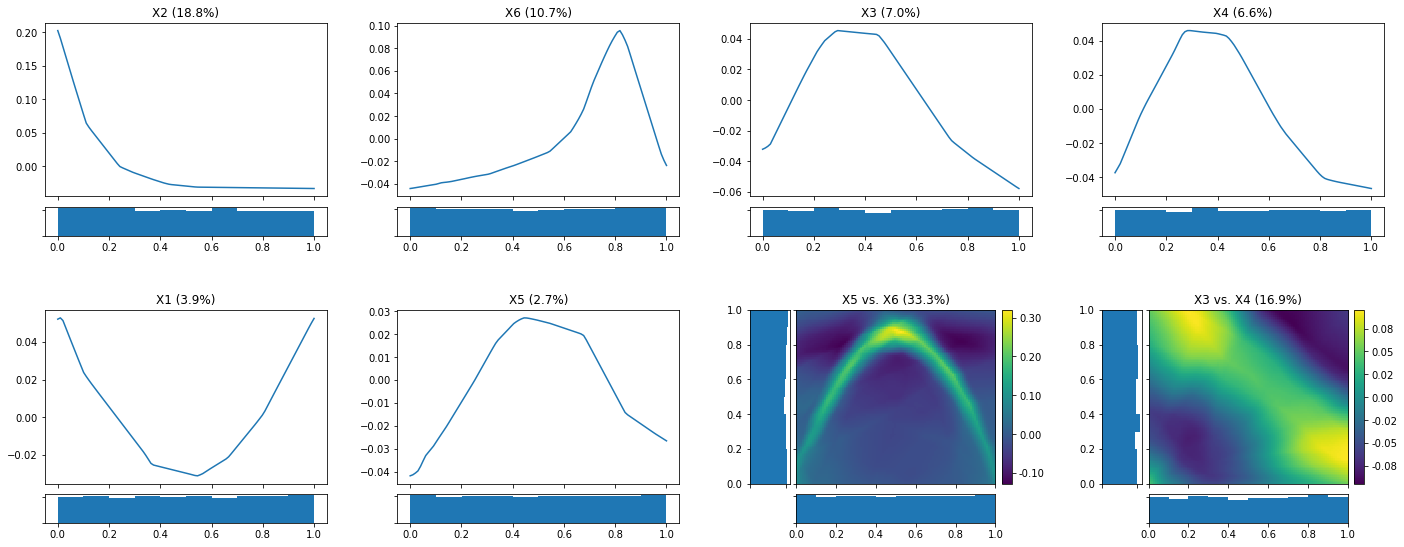

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

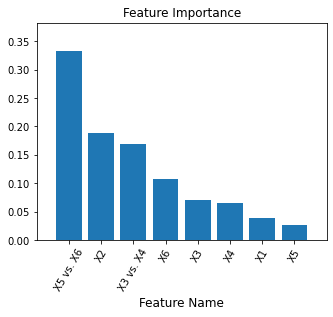

In [7]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [8]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

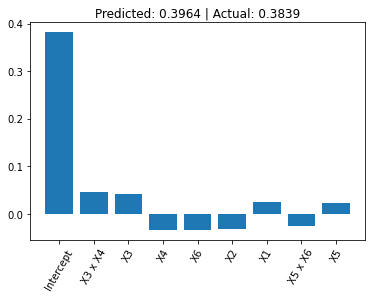

In [9]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

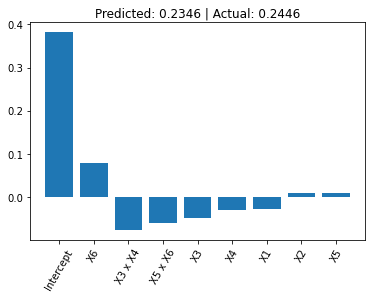

In [10]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [11]:
model.save(folder="./", name="model_saved")

In [12]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")

# Shape constraints

In [46]:
model_debug = GAMINet(meta_info=meta_info, interact_num=0, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.01, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                convex_list=[0, 1],
                mono_decreasing_list=[1], lattice_size=2,
                include_interaction_list=[(2, 3), (4, 5)],
                # manually inputted interactions are included in addition to prescreening interactions defined by interact_num.
                ## Model with Convexity Constraints are generally hard to train, try larger learning rates.
                verbose=True, val_ratio=0.2, random_state=random_state)
model_debug.fit(train_x, train_y)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.02050, val loss: 0.02065
Main effects training epoch: 2, train loss: 0.01853, val loss: 0.01872
Main effects training epoch: 3, train loss: 0.01710, val loss: 0.01775
Main effects training epoch: 4, train loss: 0.01471, val loss: 0.01532
Main effects training epoch: 5, train loss: 0.01366, val loss: 0.01416
Main effects training epoch: 6, train loss: 0.01349, val loss: 0.01391
Main effects training epoch: 7, train loss: 0.01285, val loss: 0.01337
Main effects training epoch: 8, train loss: 0.01248, val loss: 0.01266
Main effects training epoch: 9, train loss: 0.01299, val loss: 0.01328
Main effects training epoch: 10, train loss: 0.01239, val loss: 0.01268
Main effects training epoch: 11, train loss: 0.01242, val loss: 0.01270
Main effects training epoch: 12, train loss: 0.01232, val loss: 0.01259
Main effects training e

Main effects training epoch: 114, train loss: 0.01166, val loss: 0.01146
Main effects training epoch: 115, train loss: 0.01194, val loss: 0.01193
Main effects training epoch: 116, train loss: 0.01162, val loss: 0.01158
Main effects training epoch: 117, train loss: 0.01144, val loss: 0.01151
Main effects training epoch: 118, train loss: 0.01120, val loss: 0.01110
Main effects training epoch: 119, train loss: 0.01148, val loss: 0.01136
Main effects training epoch: 120, train loss: 0.01124, val loss: 0.01110
Main effects training epoch: 121, train loss: 0.01115, val loss: 0.01109
Main effects training epoch: 122, train loss: 0.01136, val loss: 0.01121
Main effects training epoch: 123, train loss: 0.01168, val loss: 0.01161
Main effects training epoch: 124, train loss: 0.01143, val loss: 0.01151
Main effects training epoch: 125, train loss: 0.01128, val loss: 0.01125
Main effects training epoch: 126, train loss: 0.01169, val loss: 0.01166
Main effects training epoch: 127, train loss: 0.011

Interaction training epoch: 96, train loss: 0.00488, val loss: 0.00485
Interaction training epoch: 97, train loss: 0.00489, val loss: 0.00487
Interaction training epoch: 98, train loss: 0.00488, val loss: 0.00483
Interaction training epoch: 99, train loss: 0.00485, val loss: 0.00481
Interaction training epoch: 100, train loss: 0.00482, val loss: 0.00480
Interaction training epoch: 101, train loss: 0.00482, val loss: 0.00479
Interaction training epoch: 102, train loss: 0.00483, val loss: 0.00481
Interaction training epoch: 103, train loss: 0.00480, val loss: 0.00477
Interaction training epoch: 104, train loss: 0.00478, val loss: 0.00473
Interaction training epoch: 105, train loss: 0.00477, val loss: 0.00474
Interaction training epoch: 106, train loss: 0.00475, val loss: 0.00470
Interaction training epoch: 107, train loss: 0.00472, val loss: 0.00468
Interaction training epoch: 108, train loss: 0.00477, val loss: 0.00474
Interaction training epoch: 109, train loss: 0.00468, val loss: 0.00

Interaction training epoch: 210, train loss: 0.00270, val loss: 0.00275
Interaction training epoch: 211, train loss: 0.00276, val loss: 0.00275
Interaction training epoch: 212, train loss: 0.00269, val loss: 0.00271
Interaction training epoch: 213, train loss: 0.00266, val loss: 0.00271
Interaction training epoch: 214, train loss: 0.00265, val loss: 0.00269
Interaction training epoch: 215, train loss: 0.00266, val loss: 0.00266
Interaction training epoch: 216, train loss: 0.00267, val loss: 0.00273
Interaction training epoch: 217, train loss: 0.00268, val loss: 0.00272
Interaction training epoch: 218, train loss: 0.00266, val loss: 0.00270
Interaction training epoch: 219, train loss: 0.00271, val loss: 0.00276
Interaction training epoch: 220, train loss: 0.00264, val loss: 0.00270
Interaction training epoch: 221, train loss: 0.00265, val loss: 0.00272
Interaction training epoch: 222, train loss: 0.00259, val loss: 0.00263
Interaction training epoch: 223, train loss: 0.00259, val loss: 

Interaction training epoch: 324, train loss: 0.00217, val loss: 0.00226
Interaction training epoch: 325, train loss: 0.00215, val loss: 0.00223
Interaction training epoch: 326, train loss: 0.00219, val loss: 0.00226
Interaction training epoch: 327, train loss: 0.00219, val loss: 0.00226
Interaction training epoch: 328, train loss: 0.00216, val loss: 0.00225
Interaction training epoch: 329, train loss: 0.00226, val loss: 0.00236
Interaction training epoch: 330, train loss: 0.00218, val loss: 0.00224
Interaction training epoch: 331, train loss: 0.00221, val loss: 0.00231
Interaction training epoch: 332, train loss: 0.00219, val loss: 0.00228
Interaction training epoch: 333, train loss: 0.00219, val loss: 0.00226
Interaction training epoch: 334, train loss: 0.00214, val loss: 0.00222
Interaction training epoch: 335, train loss: 0.00219, val loss: 0.00229
Interaction training epoch: 336, train loss: 0.00216, val loss: 0.00225
Interaction training epoch: 337, train loss: 0.00222, val loss: 

Interaction training epoch: 438, train loss: 0.00216, val loss: 0.00228
Interaction training epoch: 439, train loss: 0.00210, val loss: 0.00219
Interaction training epoch: 440, train loss: 0.00211, val loss: 0.00221
Interaction training epoch: 441, train loss: 0.00208, val loss: 0.00217
Interaction training epoch: 442, train loss: 0.00209, val loss: 0.00217
Interaction training epoch: 443, train loss: 0.00211, val loss: 0.00220
Interaction training epoch: 444, train loss: 0.00211, val loss: 0.00221
Interaction training epoch: 445, train loss: 0.00210, val loss: 0.00219
Interaction training epoch: 446, train loss: 0.00209, val loss: 0.00219
Interaction training epoch: 447, train loss: 0.00209, val loss: 0.00219
Interaction training epoch: 448, train loss: 0.00211, val loss: 0.00220
Interaction training epoch: 449, train loss: 0.00210, val loss: 0.00219
Interaction training epoch: 450, train loss: 0.00209, val loss: 0.00218
Interaction training epoch: 451, train loss: 0.00216, val loss: 

Fine tuning epoch: 60, train loss: 0.00203, val loss: 0.00213
Fine tuning epoch: 61, train loss: 0.00210, val loss: 0.00223
Fine tuning epoch: 62, train loss: 0.00202, val loss: 0.00212
Fine tuning epoch: 63, train loss: 0.00204, val loss: 0.00217
Fine tuning epoch: 64, train loss: 0.00207, val loss: 0.00218
Fine tuning epoch: 65, train loss: 0.00209, val loss: 0.00222
Fine tuning epoch: 66, train loss: 0.00200, val loss: 0.00211
Fine tuning epoch: 67, train loss: 0.00202, val loss: 0.00213
Fine tuning epoch: 68, train loss: 0.00202, val loss: 0.00213
Fine tuning epoch: 69, train loss: 0.00207, val loss: 0.00217
Fine tuning epoch: 70, train loss: 0.00199, val loss: 0.00211
Fine tuning epoch: 71, train loss: 0.00206, val loss: 0.00215
Fine tuning epoch: 72, train loss: 0.00204, val loss: 0.00217
Fine tuning epoch: 73, train loss: 0.00207, val loss: 0.00220
Fine tuning epoch: 74, train loss: 0.00205, val loss: 0.00215
Fine tuning epoch: 75, train loss: 0.00201, val loss: 0.00214
Fine tun

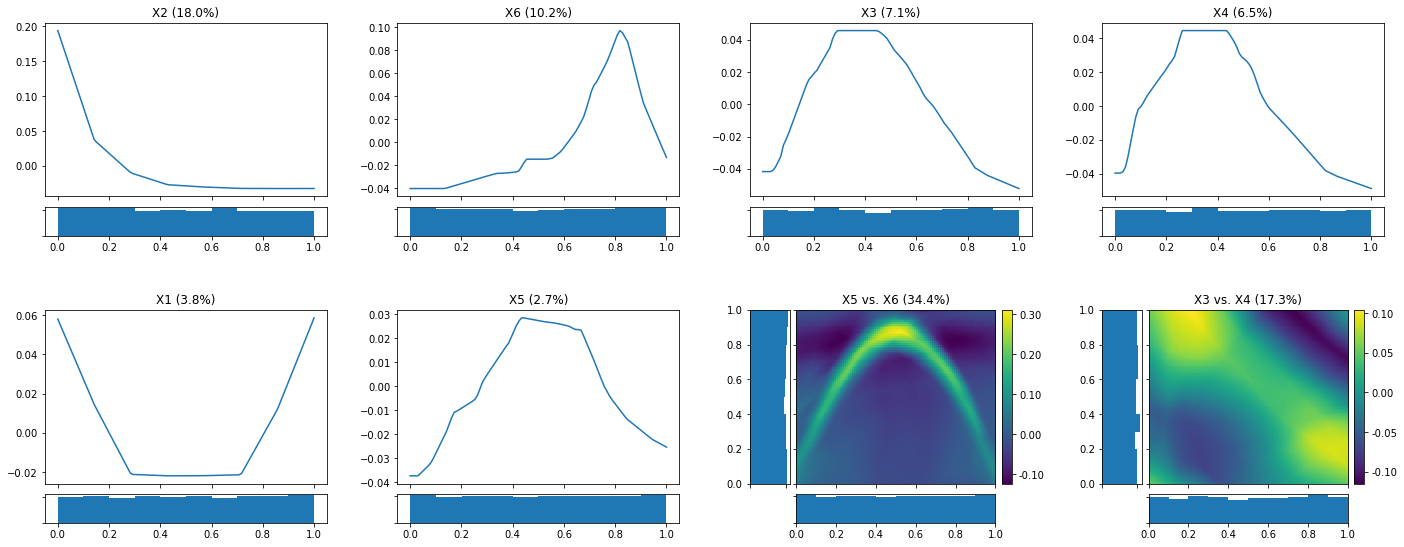

In [47]:
# The interactions are also constrained to be convex or concave, which is very different from the ground truth.
# (Decreased Predictive Performance)

data_dict_global = model_debug.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=False)